In [1]:
import keras

Using TensorFlow backend.


In [0]:
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, Input, MaxPooling2D, Reshape
from keras import optimizers
from keras import backend as K
from keras.utils import to_categorical 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.model_selection import train_test_split 

import pickle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
# sys.path += ['/Users/hsi/Documents/study/data_course_antonec_2018/data_course/']

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
path = '/content/gdrive/My Drive/winter_school_2019/seismic_images/Lapteva_faults_10k.pickle'
with open(path, 'rb') as handle:
    data = pickle.load(handle)
    
X = data['X_set'] 
y = data['y_set'] 
X = X.reshape(X.shape + (1,))
y = y.reshape(y.shape + (1,))
Titles = data['fault_title'] 
y.shape

(10240, 64, 64, 1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=25)

y_train = to_categorical(y_train, num_classes=2) 
y_test = to_categorical(y_test, num_classes=2)

In [30]:
print(x_train.shape)
print(y_train.shape)

(9216, 64, 64, 1)
(9216, 64, 64, 2)


In [0]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

In [0]:
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D
from keras.models import Model
from keras.optimizers import Adam

def create_model(
        activation='relu',
        depth=15,
        batch_norm=.3,
        dropout=.3,
        activation_out='sigmoid',
        lr=.001,
        pooling=False,
        weight_false=0.5,
        weight_true=1,
):
    x = input_img = Input(shape=(64, 64, 1))

    neur = 32
    for i in range(depth):
      neur *= 1
      x = Conv2D(neur, (3, 3), activation=activation, padding='same')(x)
      x = BatchNormalization()(x) if batch_norm else x
      x = Dropout(dropout)(x) if dropout else x
      x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) if pooling else x
        
    x = Flatten()(x)    
    x = Dense(100, activation=activation)(x)    
    x = Dropout(dropout)(x) if dropout else x
    x = Dense(64 * 64 * 2, activation=activation_out)(x)
    x = Reshape((64, 64, 2), input_shape=(64 * 64 * 2,))(x)
    
    loss = weighted_categorical_crossentropy(np.array([weight_false, weight_true]))
    
    model = Model(input_img, x, name="classification")
    model.compile(
        optimizer=Adam(lr=lr),
#         loss='binary_crossentropy', 
        loss=loss,
        metrics=['accuracy']
    )
    return model


In [50]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_44 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
dropout_50 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_45 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
dropout_51 (Dropout)         (None, 64, 64, 32)        0         
__________

In [51]:
model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_split=.3,
)

Train on 6451 samples, validate on 2765 samples
Epoch 1/100
6451/6451 [==============================] - 45s 7ms/step - loss: 0.1310 - acc: 0.9556 - val_loss: 0.1375 - val_acc: 0.9690
Epoch 2/100
6451/6451 [==============================] - 39s 6ms/step - loss: 0.1169 - acc: 0.9685 - val_loss: 0.1981 - val_acc: 0.9690
Epoch 3/100
6451/6451 [==============================] - 39s 6ms/step - loss: 0.1127 - acc: 0.9685 - val_loss: 0.1591 - val_acc: 0.9690
Epoch 4/100
6451/6451 [==============================] - 39s 6ms/step - loss: 0.1093 - acc: 0.9685 - val_loss: 0.1272 - val_acc: 0.9689
Epoch 5/100
6451/6451 [==============================] - 38s 6ms/step - loss: 0.1070 - acc: 0.9686 - val_loss: 0.1108 - val_acc: 0.9689
Epoch 6/100
6451/6451 [==============================] - 38s 6ms/step - loss: 0.1038 - acc: 0.9686 - val_loss: 0.1183 - val_acc: 0.9690
Epoch 7/100
6451/6451 [==============================] - 38s 6ms/step - loss: 0.1010 - acc: 0.9686 - val_loss: 0.1059 - val_acc: 0.9691


In [0]:

%matplotlib inline
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

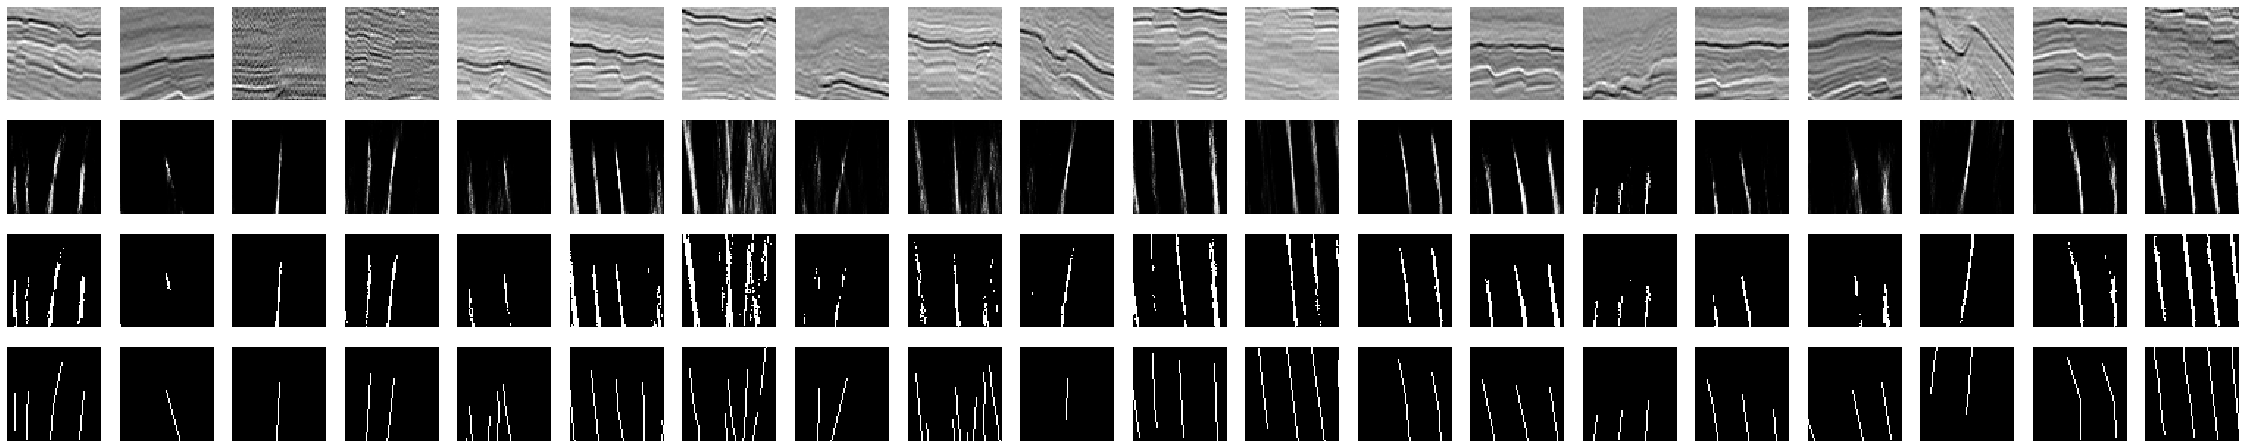

In [53]:
n = 20
trash = 0.30

answers = y_test[:n, :, :, 1:]
imgs = x_test[:n]
predicted = model.predict(imgs, batch_size=n)[:, :, :, 1:]
predicted_bool = predicted > trash
plot_digits(imgs, predicted, predicted_bool, answers)


In [0]:
from sklearn.metrics import classification_report
y_score = model.predict(x_test, batch_size=n)[:, :, :, 1:]
y_label = y_test[:, :, :, 1:] > 0.1

y_score = y_score.reshape([y_score.size,])
y_label = y_label.reshape([y_label.size,])


In [55]:
print(y_score.shape)
print(y_label.shape)

(4194304,)
(4194304,)


Text(0.5, 1.0, 'curve')

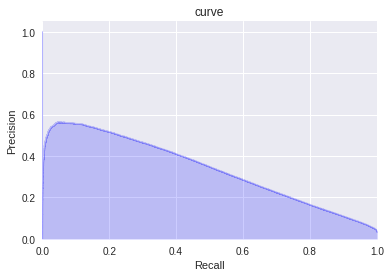

In [56]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_label, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('curve')